In [1]:
#General settings
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob
sn.set_context('notebook')
import numpy as np
import pylab as pl
import statsmodels.api as sm

from read_parameters import loadPerformance, loadLimits, readMARS
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:9

# Sensitivity and Uncertainty Analysis in streamflow at Langtjern using PERSiST

## Data and methods

Daily meteorological data (p,t) for the period 1973–2013 was used.

Daily streamflow at the "LAE03" was used for model not validation.

First an overview of the discharge data at "LAE03":

C:\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


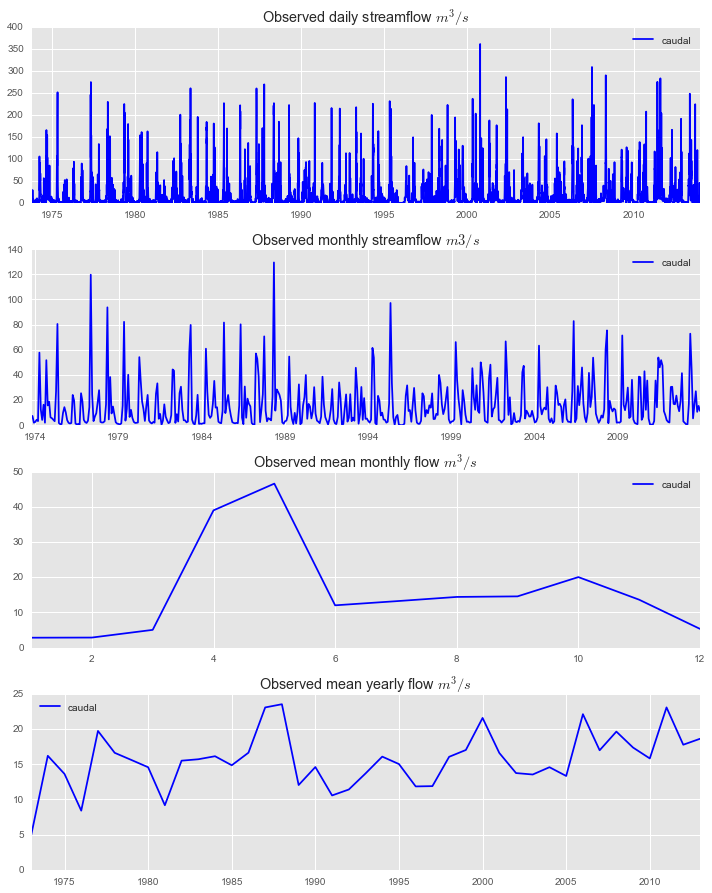

In [2]:
matplotlib.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (10, 12.5)

#Reading in flow data
flow_file=r"C:\Users\PERSIST\Langtjern_20150331_MartynF\JL_test\useMe_1973.obs"
flow_data = pd.read_csv(flow_file,'\t',header=2,nrows=14698,names=['fecha','caudal'],index_col='fecha')
flow_data.index = pd.date_range('10-5-1973', periods=14698, freq='D')

rain_file=r"C:\Users\PERSIST\Langtjern_20150331_MartynF\JL_test\UseMe.dat"
rain_data = pd.read_csv(rain_file,'\t',header=2,nrows=14635,names=['p','t'])
rain_data.index = pd.date_range('1-1-1970', periods=14635, freq='D')
    
flow_data.caudal = flow_data.caudal*1000    
#flow_data=flow_data['1989/1/1':]    

fig, ax = plt.subplots(nrows=4)

#Plotting the daily data
flow_data.plot(title='Observed daily streamflow $m^3/s$',ax=ax[0],color='blue')

#Plotting monthly data
monthly_flow = flow_data.resample('M').mean()
monthly_flow.plot(title='Observed monthly streamflow $m3/s$',ax=ax[1],color='blue')

#Plotting average monthly data
monthly_mean = flow_data.groupby(flow_data.index.month).aggregate(np.mean)
monthly_mean.plot(title='Observed mean monthly flow $m^3/s$',ax=ax[2],color='blue')

#Plotting average yearly data
yearly_mean = flow_data.resample('A').mean()
yearly_mean.plot(title='Observed mean yearly flow $m^3/s$',ax=ax[3],color='blue')

plt.tight_layout()

plt.show()

There seems to be a trend in the discharge data. Let's check if it is significant, but excluding the first year of data since it is incomplete:

                            OLS Regression Results                            
Dep. Variable:                 caudal   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.557
Date:                Mon, 13 Jun 2016   Prob (F-statistic):             0.0670
Time:                        09:43:40   Log-Likelihood:                -105.84
No. Observations:                  40   AIC:                             215.7
Df Residuals:                      38   BIC:                             219.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         14.0013      1.128     12.413      0.0

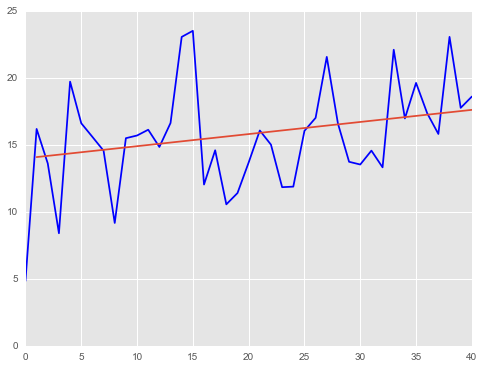

In [3]:
x = np.arange(yearly_mean.count())
X = sm.add_constant(x)
y = yearly_mean['caudal']
res = sm.OLS(y[1:],X[1:]).fit()
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'b-', label="Yearly average streamflow")
ax.plot(x[1:], res.fittedvalues, label="Linear fit")

print(res.summary())

There does not appear to be a trend in the yearly data. 
There appears to be, however, a change in the data in 1989.
If we repeat the trend analysis for that period:


                            OLS Regression Results                            
Dep. Variable:                 caudal   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     13.34
Date:                Mon, 13 Jun 2016   Prob (F-statistic):            0.00140
Time:                        09:43:40   Log-Likelihood:                -56.922
No. Observations:                  24   AIC:                             117.8
Df Residuals:                      22   BIC:                             120.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         12.3063      1.141     10.784      0.0

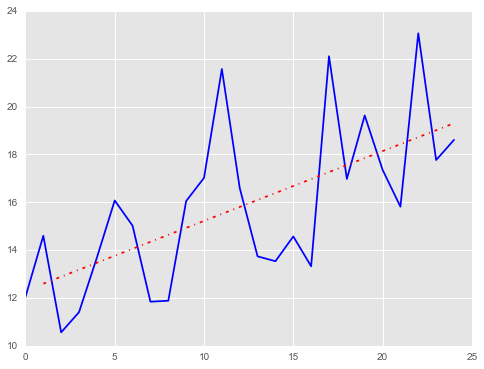

In [4]:
subset_1989 = flow_data['1989/1/1':]
subset_1989_Y = subset_1989.resample('A').mean()
x = np.arange(subset_1989_Y.count())
X = sm.add_constant(x)
y = subset_1989_Y['caudal']
res = sm.OLS(y[1:],X[1:]).fit()
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'b-', label="Yearly average streamflow")
ax.plot(x[1:], res.fittedvalues, 'r-.', label="Linear fit")

subset_1973_Y = flow_data['1974/1/1':'1988/12/31'].resample('A').mean()

print(res.summary())
print(stats.ks_2samp(subset_1973_Y.caudal,subset_1989_Y.caudal))

And in this case the trend appears to be significant. This could point to:

1. Changes in how the data was measured
2. Changes in the catchment
3. Changes in the climate.

It should be noted, however that performing the Kolmogorov-Smirnov test on the two periods pre and post 1989, one cannot reject the hypothesis that the samples come from the same distribution. 

### Methods: GLUE

GLUE is a global sensitivity analysis and uncertainty evaluation method that, at its most basic, randomly sample parameters values within predefined ranges and computes a performance measure for the different parameter values combinations, that allows ranking the different parameter combination and compute uncertainty bounds from these rankings. 

The results depend primarily on the objective function, a measure of the goodness of fit between observed and simulated discharge and the behevioral threshold, a measure beyond which the fit is considered "good enough".

The PERSiST hydrological model was used to simulate discharge. A problem for the application of GLUE and other sensitivity analysis methods is that the computational requirements grow exponentially with the dimensionality of the problem.

Here is a list of the free parameters in the PERSiST setup at Langtjern, with their sampling range:

dimension = 88<br\>
   variable 1 forest:snow:Snow_multiplier = 0.5 1.5 <br\>
   variable 2 mire:snow:Snow_multiplier = 0.5 1.5 <br\>
   variable 3 forest:snow:Melt_temperature = -5 10 <br\>
   variable 4 mire:snow:Melt_temperature = -5 10 <br\>
   variable 5 forest:snow:Degree_day_melt = 0 20<br\>
   variable 6 mire:snow:Degree_day_melt = 0 20<br\>
   variable 7 forest:snow:Rain_multiplier = 0.5 1.5<br\>
   variable 8 mire:snow:Rain_multiplier = 0.5 1.5<br\>
   variable 9 forest:snow:Initial_depth = 0 100<br\>
   variable 10 mire:snow:Initial_depth = 0 100<br\>
   variable 11 forest:snow:Growing_degree = -5 10<br\>
   variable 12 mire:snow:Growing_degree = -5 10<br\>
   variable 13 forest:snow:Degree_day_ETP = 0.01 0.2<br\>
   variable 14 mire:snow:Degree_day_ETP = 0.01 0.2<br\>
   variable 15 forest:snow:Canopy_interception = 0 1<br\>
   variable 16 mire:snow:Canopy_interception = 0 1<br\>
   variable 17 forest:direct_runoff:Initial_depth = 0 1000<br\>
   variable 18 mire:direct_runoff:Initial_depth = 0 1000<br\>
   variable 19 forest:direct_runoff:RAI = 0 1<br\>
   variable 20 mire:direct_runoff:RAI = 0 1<br\>
   variable 21 forest:direct_runoff:Infiltration = 0 200<br\>
   variable 22 mire:direct_runoff:Infiltration = 0 200<br\>
   variable 23 forest:direct_runoff:Retained_water_depth = 0 500<br\>
   variable 24 mire:direct_runoff:Retained_water_depth = 0 500<br\>
   variable 25 forest:direct_runoff:Direct_runoff_fraction = 0 1<br\>
   variable 26 mire:direct_runoff:Direct_runoff_fraction = 0 1<br\>
   variable 27 forest:direct_runoff:Time_constant = 1 5<br\>
   variable 28 mire:direct_runoff:Time_constant = 1 5<br\>
   variable 29 forest:direct_runoff:ETP_adjustment = 1 20<br\>
   variable 30 mire:direct_runoff:ETP_adjustment = 1 20<br\>
   variable 31 forest:direct_runoff:Relative_ETP_index = 0.075 0.25<br\>
   variable 32 mire:direct_runoff:Relative_ETP_index = 0.075 0.25<br\>
   variable 33 forest:direct_runoff:Maximum_capacity = 0 500<br\>
   variable 34 mire:direct_runoff:Maximum_capacity = 0 500<br\>
   variable 35 forest:direct_runoff:Inundation_threshold = 0 500<br\>
   variable 36 mire:direct_runoff:Inundation_threshold = 0 500<br\>
   variable 37 forest:direct_runoff:Porosity = 0 1<br\>
   variable 38 mire:direct_runoff:Porosity = 0 1<br\>
   variable 39 forest:direct_runoff:Inundation_offset = 0 1<br\>
   variable 40 mire:direct_runoff:Inundation_offset = 0 1<br\>
   variable 41 forest:soil_water:Initial_depth = 0 1000<br\>
   variable 42 mire:soil_water:Initial_depth = 0 1000<br\>
   variable 43 forest:soil_water:RAI = 0 1<br\>
   variable 44 mire:soil_water:RAI = 0 1<br\>
   variable 45 forest:soil_water:Infiltration = 0 100<br\>
   variable 46 mire:soil_water:Infiltration = 0 100<br\>
   variable 47 forest:soil_water:Retained_water_depth = 0 200<br\>
   variable 48 mire:soil_water:Retained_water_depth = 0 200<br\>
   variable 49 forest:soil_water:Drought_runoff_fraction = 0 1<br\>
   variable 50 mire:soil_water:Drought_runoff_fraction = 0 1<br\>
   variable 51 forest:soil_water:Time_constant = 1 10<br\>
   variable 52 mire:soil_water:Time_constant = 1 10<br\>
   variable 53 forest:soil_water:ETP_adjustment = 1 20<br\>
   variable 54 mire:soil_water:ETP_adjustment = 1 20<br\>
   variable 55 forest:soil_water:Relative_ETP_index = 0 1<br\>
   variable 56 mire:soil_water:Relative_ETP_index = 0 1<br\>
   variable 57 forest:soil_water:Maximum_capacity = 0 500<br\>
   variable 58 mire:soil_water:Maximum_capacity = 0 500<br\>
   variable 59 forest:soil_water:Inundation_threshold = 0 500<br\>
   variable 60 mire:soil_water:Inundation_threshold = 0 500<br\>
   variable 61 forest:soil_water:Porosity = 0 1<br\>
   variable 62 mire:soil_water:Porosity = 0 1<br\>
   variable 63 forest:soil_water:Inundation_offset = 0 1<br\>
   variable 64 mire:soil_water:Inundation_offset = 0 1<br\>
   variable 65 forest:groundwater:Initial_depth = 0 1000<br\>
   variable 66 mire:groundwater:Initial_depth = 0 1000<br\>
   variable 67 forest:groundwater:RAI = 0 1<br\>
   variable 68 mire:groundwater:RAI = 0 1<br\>
   variable 69 forest:groundwater:Infiltration = 0 100<br\>
   variable 70 mire:groundwater:Infiltration = 0 100<br\>
   variable 71 forest:groundwater:Retained_water_depth = 0 200<br\>
   variable 72 mire:groundwater:Retained_water_depth = 0 200<br\>
   variable 73 forest:groundwater:Drought_runoff_fraction = 0 1<br\>
   variable 74 mire:groundwater:Drought_runoff_fraction = 0 1<br\>
   variable 75 forest:groundwater:Time_constant = 1 365<br\>
   variable 76 mire:groundwater:Time_constant = 1 365<br\>
   variable 77 forest:groundwater:ETP_adjustment = 1 20<br\>
   variable 78 mire:groundwater:ETP_adjustment = 1 20<br\>
   variable 79 forest:groundwater:Relative_ETP_index = 0 1<br\>
   variable 80 mire:groundwater:Relative_ETP_index = 0 1<br\>
   variable 81 forest:groundwater:Maximum_capacity = 0 500<br\>
   variable 82 mire:groundwater:Maximum_capacity = 0 500<br\>
   variable 83 forest:groundwater:Inundation_threshold = 0 500<br\>
   variable 84 mire:groundwater:Inundation_threshold = 0 500<br\>
   variable 85 forest:groundwater:Porosity = 0 1<br\>
   variable 86 mire:groundwater:Porosity = 0 1<br\>
   variable 87 forest:groundwater:Inundation_offset = 0 1<br\>
   variable 88 mire:groundwater:Inundation_offset = 0 1<br\>


### Methods: Sensitivity analysis with PSUADE

PSUADE is a freely available library that provides an array of sensitivity analysis methods. Here we test a few of them.
In a similar fashion to GLUE, the number of free parameters is a limitation which is exacerbated by numerical instabilities.
Some of these methods rely on matrix operations. The size of said matrices is proportional to the number of parameters and the stability issues are only worsened in the presence of correlations between parameters, something unavoidable in overparameterized models.

Both GLUE and PSUADE are implemented in C++ and we present here a postprocessing of the data.

## Results: GLUE

The GLUE analysis was run for the period 1982-2023. The model was run for the period 1973-2013

The GLUE implementation provides an array of possible objective functions. Let us start showing the classic Nash-Sutcliffe efficiency using "dotty plots" and the 5% and 95% uncertainty bounds for the discharge.

The dotty plots show parameter values in the x-axis and the performance on the y-axis. Each dot is the performance for a certain parameter-value combinations (one random value for each of the parameters listed above).







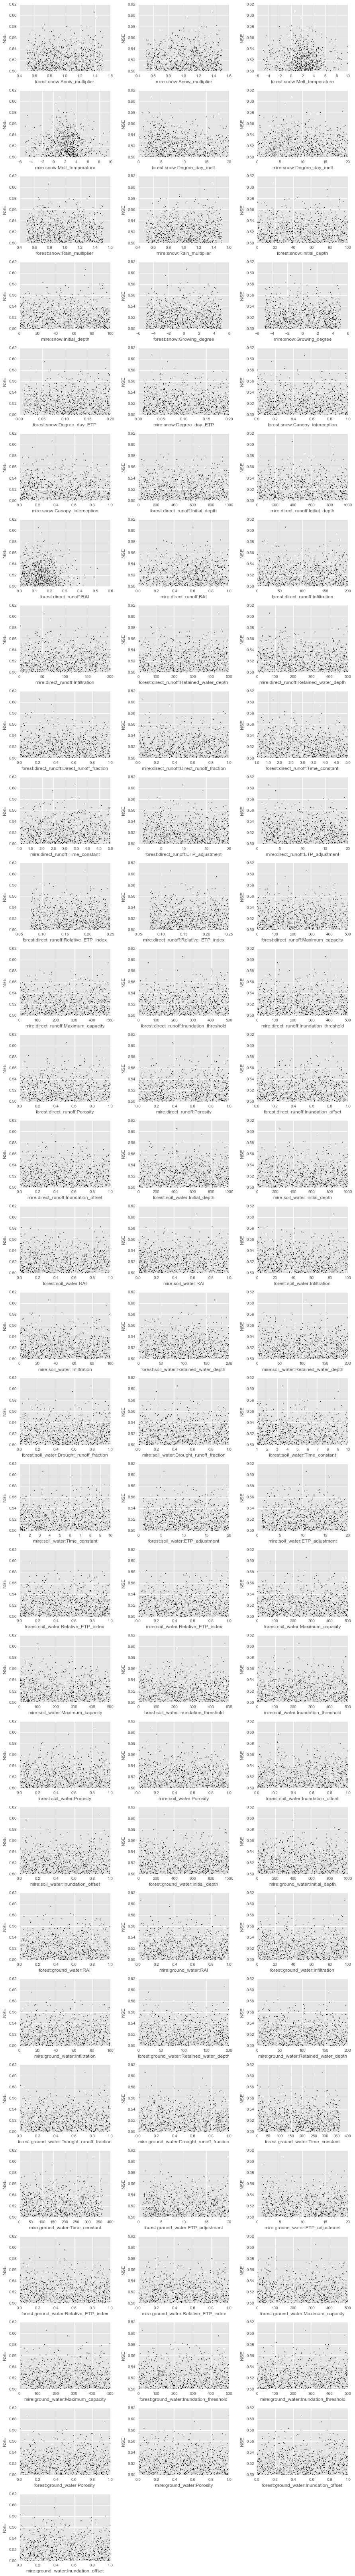

In [5]:
pylab.rcParams['figure.figsize'] = (12.5, 90)
(names,values) = loadPerformance('Performance_and_parameters_NSE250k.txt')
performance=values[:,0]
numCol = len(names)
idx = 1
for column in values[:, 1:].T:
    plt.subplot(30,3,idx)
    plt.plot(column,performance,'k.',MarkerSize=3)
    plt.xlabel(names[idx-1][0] + ':' + names[idx-1][1] + ':' + names[idx-1][2])
    plt.ylabel('NSE')
    idx = idx + 1
    
plt.tight_layout()

*Some text about what we can see in the dotty plots. Not enough simulations to be conclusive right now*

And we can also look at the uncertainty bounds for the simulations

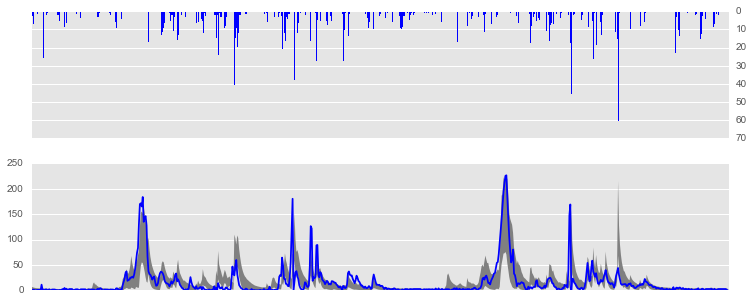

In [10]:
bounds = loadLimits('Behavioral_limits_NSE250k.txt')
bounds = bounds.multiply(1000)

w_start = '1984/1/1'
w_end =  '1985/12/31'

fig, ax = plt.subplots(2, sharex=True)
pylab.rcParams['figure.figsize'] = (12.5, 7.5)
#ax2 = ax1#.twinx() 
#= fig.add_axes(ax1.get_position(), frameon=False)

ax[1].plot(flow_data[w_start:w_end].index,flow_data[w_start:w_end].caudal,'b-')
sub = bounds[w_start:w_end]
ax[1].fill_between(sub.index,sub['quant:0.025'],sub['quant:0.975'],facecolor='grey',edgecolor='none')


temp=rain_data[w_start:w_end]
ax[0].bar(temp.index,temp['p'],color='blue',edgecolor='none')
ax[0].get_xaxis().set_ticks([])
ax[0].invert_yaxis()
ax[0].yaxis.tick_right()

plt.show()

#print(flow_data)
#print(sub)

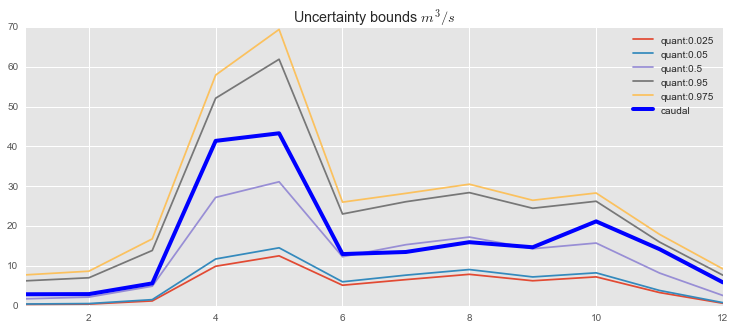

In [7]:
#Plotting uncertain mean
#figure()
pylab.rcParams['figure.figsize'] = (12.5, 5)
uncertain_month = bounds.groupby(bounds.index.month).aggregate(np.mean)
observed_q_month = flow_data['1982/1/1':'2013/12/31'].groupby(flow_data['1982/1/1':'2013/12/31'].index.month).aggregate(np.mean)
ax=uncertain_month.plot(title='Uncertainty bounds $m^3/s$')
observed_q_month.plot(ax=ax,color='blue',LineWidth=4)
plt.show()

We can see that there is a rater stark difference for the streamflow when using different objective functions.

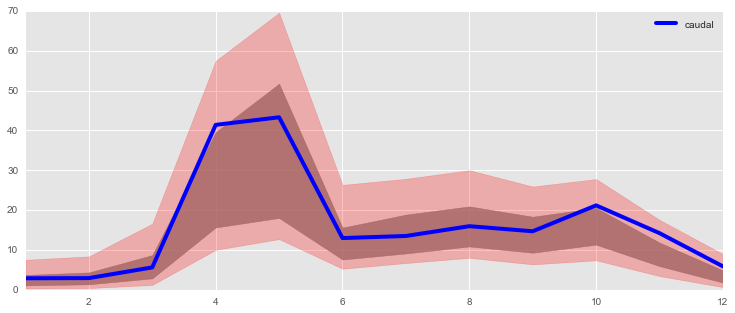

In [8]:
uncertain_month_MME = loadLimits('Behavioral_limits_MME100k.txt')
uncertain_month_NSE = loadLimits('Behavioral_limits_NSE100k.txt')
uncertain_month_MME = uncertain_month_MME.groupby(uncertain_month_MME.index.month).aggregate(np.mean)*1000
uncertain_month_NSE = uncertain_month_NSE.groupby(uncertain_month_NSE.index.month).aggregate(np.mean)*1000
#figure()
pylab.rcParams['figure.figsize'] = (12.5, 5)
ax = observed_q_month.plot(color='blue',LineWidth=4)
ax.fill_between(uncertain_month_MME.index,uncertain_month_MME['quant:0.025'],uncertain_month_MME['quant:0.975'],alpha=0.75,color='grey',label='MME')
ax.fill_between(uncertain_month_NSE.index,uncertain_month_NSE['quant:0.025'],uncertain_month_NSE['quant:0.975'],alpha=0.25,color='red',label='NSE')
pl.show()

## Results: Sensitivity Analysis

Let's look at different sentivity analyis methods and their 
results

### MARS

Multi-adaptive regression splines. Response surface fitting, provides relative rankings.

[  26.14     5.925   12.41     0.       0.       0.      46.02     8.297
    0.       0.       9.929    0.       9.172    0.       7.856    0.       0.
    0.     100.      15.25     0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       5.218
    3.397    0.       0.       0.       0.       0.       0.       0.
    6.261    0.       3.728    0.       0.       0.       0.       0.       0.
    0.       0.       0.       3.674    0.       7.198    0.       0.
    2.287    0.       0.       8.249    0.       0.       0.       4.786
    0.       0.       0.       0.       0.       0.       0.       5.036
    0.       0.       0.       4.993    0.       0.       0.       0.       0.
    8.348    0.       0.       0.   ]


C:\Anaconda3\lib\site-packages\numpy\lib\npyio.py:891: UserWarning: loadtxt: Empty input file: "<_io.StringIO object at 0x0DEB3490>"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


<Container object of 88 artists>

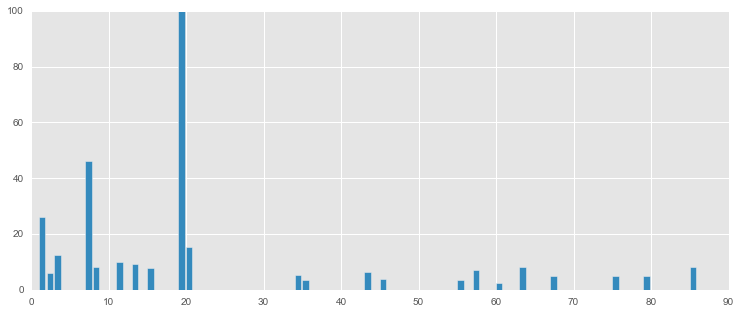

In [9]:
(num,rank) = readMARS('MARS.txt')
print(rank)
pylab.rcParams['figure.figsize'] = (12.5, 5)
plt.bar(num,rank)